In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import numpy as np
import math
import numba
from numba import cuda, int64, jit
from numba.cuda import random as rnd
from timeit import default_timer as timer
from scipy.stats import binom, poisson
import pickle as pkl
import os

In [2]:
!nvidia-smi

Thu Dec 18 14:48:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:C1:00.0 Off |                  Off |
| 30%   34C    P8             14W /  450W |     797MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 0. random number on a GPU

First, we would like to sample a unformly distributed random variable.

For our example later this can represent sampling a random parent for a cell.





In [ ]:


# @cuda.jit
# def random_draw(out):
#     """draws a random number"""
#     thread_id = cuda.grid(1)

#     out[thread_id] = np.random.random()



# threads_per_block = 32
# blocks = 1
# out = np.zeros(threads_per_block * blocks, dtype=np.float32)

# random_draw[blocks, threads_per_block](out)
# print( out )


We cannot generate random numbers on the GPU using numpy functions, among other because the API cannot access the random state of the pseudorandom generator.

Furthermore, as we are performing this number generation in parallel, we need to provide **one seed per thread**, otherwise each thread would be generating the same "random" number.

Thnakfully numba cuda has a [random submodule](https://numba.pydata.org/numba-doc/0.33.0/cuda/random.html) to help us handle all this, with helpful functions to generate uniformly or normally distributed numbers.

> The algorithm they use for random number generation is called xoroshiro128+ so all functions are called `*_xoroshiro128p_*`

In [3]:
from numba.cuda import random as rnd

@cuda.jit
def random_draw(random_states,out):
    """draws a random number - version 2"""
    thread_id = cuda.grid(1)

    ## generating a random float in the interval [0,1)
    ## the function takes the random states and current thread id (to know which of the state this thread should use)
    out[thread_id] = rnd.xoroshiro128p_uniform_float32(random_states, thread_id)



threads_per_block = 32
blocks = 1
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

## we initialize some random states for the pseudorandom generator.
## With one state per thread in the grid
rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

random_draw[blocks, threads_per_block](rng_states,out)
print( out )


/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


[0.13312314 0.87634873 0.8710909  0.93648076 0.6059929  0.34505194
 0.47981444 0.3305011  0.40937707 0.29912177 0.44444534 0.85827196
 0.07629146 0.08610503 0.52577114 0.65673774 0.9856631  0.08555376
 0.87293905 0.85164315 0.9950363  0.02283849 0.20138659 0.2973625
 0.7238183  0.82511115 0.7706651  0.56819165 0.92545813 0.2543416
 0.2508346  0.5220425 ]


/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:934: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [4]:
## the rng states are sets of numbers
rng_states.copy_to_host()

array([( 6973970356650672430,                    0),
       ( 9779246722794921790, 12546491321398146587),
       (  936820135712749323,  7440126275378544260),
       (15049798470382804179,  2068090975599410875),
       ( 5689512426501389403,  1820456906521155543),
       (11330740796713033172,  3753280129817718537),
       ( 2153910818713775775, 12380673516335860584),
       ( 7949200919083815107,  7939871054673181147),
       ( 4389062498913036047,  4461982314671172278),
       ( 4137444300713468735, 10370284953233248934),
       (14541298325770392852, 18086625517488383035),
       (11084666219414604610, 16052418609824155251),
       (13921773881697359638, 11307028273704901267),
       (15583773562375840986, 14121228188638980111),
       (17297974501053859131, 13737897126087161995),
       ( 2882460247451462029, 16748277341335022612),
       ( 4481482555253623526, 12977179980745215696),
       (13852863945840736889, 18030404642997624281),
       (17348361211214363073, 1186142732168979

In [5]:
## if we draw some new numbers, we can see that htey are different
random_draw[blocks, threads_per_block](rng_states,out)
print( out )

[0.3780597  0.21028069 0.45411518 0.92796266 0.40711626 0.8177064
 0.78792137 0.86134833 0.4798161  0.7864656  0.7687633  0.47110432
 0.3676561  0.6103114  0.682458   0.06418442 0.946436   0.72839546
 0.5834658  0.12239309 0.05057234 0.07890519 0.44578424 0.57367724
 0.13483612 0.22659232 0.24765086 0.20474549 0.5650498  0.26299164
 0.61134    0.38254791]


In [6]:
rng_states

In [7]:
## and the random states have been updated
rng_states.copy_to_host()

array([(15473625897461097326,  7226046381377999215),
       ( 9544911571744056618, 16632517257310545745),
       (15501895298621342260,   484305145024100842),
       (10884275704152675142,  4221604086774801156),
       (15326179645034385170, 14774824685861054481),
       ( 7949141682633457523,  7252816141688196555),
       (14418640417721369312,  6949722158537664734),
       ( 3133291104590721168,  6919377856545074027),
       (14596023411177542698,  5475492658771330318),
       ( 5276512584791412552,  5721570006854535473),
       (15735134746931655237,  4539367785051504064),
       (11995902411127402580, 15611960193029507578),
       ( 8847586950420168046, 12228636751524732342),
       ( 8539230009577539655, 15591687660882629716),
       (15524960120916080626, 14251600359997901034),
       ( 5768455585716635181,  1693451986555747644),
       (12611584816585016435,  8797855988751633606),
       (16226234647734432829, 13593686681260257834),
       (15298824459715353727,  456693172593545

From there, if we want to generate numbers in more *exotic* distributions we will have to play around with this random float.


In [8]:
@cuda.jit
def GPU_randint(random_states,out,N):
    """draws a random integer between 0 and N (excluded)"""
    thread_id = cuda.grid(1)

    out[thread_id] = int(N*rnd.xoroshiro128p_uniform_float32(random_states, thread_id))

threads_per_block = 32
blocks = 1
out = np.zeros(threads_per_block * blocks, dtype=np.int32)

## we initialize some random states for the pseudorandom generator.
## With one state per thread in the grid
rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

GPU_randint[blocks, threads_per_block](rng_states,out,50)
print( out )



[ 6 43 43 46 30 17 23 16 20 14 22 42  3  4 26 32 49  4 43 42 49  1 10 14
 36 41 38 28 46 12 12 26]


/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))
/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:934: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


So from here, in order to set up a system of evolving genomes we will need to devise a number of procedures to

 * randomly select one parent based on their fitness

 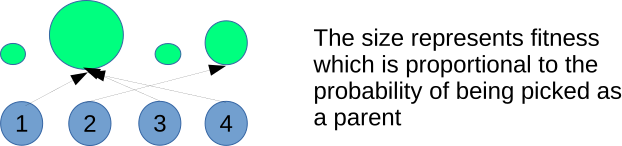

 * randomly mutate a genome
 * update the fitness of genomes
 * repeats the operation for each generation

## 1. choose a parent according to their fitness

We would like to sample a multinomially distributed random variable according to weights correspondong to fitnesses.

We start with a helper function which computes the sum of all fitnesses (using a [reduction](https://numba.pydata.org/numba-doc/dev/cuda/reduction.html) function):


In [9]:
@cuda.reduce
def sum_reduce(a, b):
  """ compute the sum of all elements in an array"""
  return a+b

In [10]:
@cuda.jit
def multinomial(rng_states,out,fitnessarr,fitness_sum):
  """
    Randomly draws parents for each cells according to their fitnesses

      args:
        - rng_states   : array of xoroshiro random states (size equal to output array)
        - out          : output array containing the randomly drawn index of the parent for each individual
        - fitnessarr   : array of parent fitnesses
        - fitness_sum  : sum of all parent fitnesses
  """
  cellID = cuda.grid(1)
  #this is how you would get a multinomially distributed random variable
  r=fitness_sum*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
  for i in range(len(fitnessarr)):
    if r<fitnessarr[i]:
      parent=i
      break
    else:
      r-=fitnessarr[i]
  out[cellID]=parent

In [11]:
## let's test it
N = 100_000
threads_per_block = 32
blocks = math.ceil( N/threads_per_block )

fitness_array = np.ones( N , dtype = np.float32 ) # simple test with all fitness = 1
out = np.zeros(N, dtype=np.int32)

## sending data to device
fitness_array_device = cuda.to_device(fitness_array)
out_device = cuda.to_device(out)

## computing fitness sum:
fitness_sum=sum_reduce(fitness_array_device)

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

multinomial[blocks, threads_per_block](rng_states,
                                     out_device,
                                     fitness_array_device,
                                     fitness_sum)



/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))
/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


In [12]:
%%timeit -n 5 -r 3
fitness_sum=sum_reduce(fitness_array_device)

multinomial[blocks, threads_per_block](rng_states,
                                     out_device,
                                     fitness_array_device,
                                     fitness_sum)
cuda.synchronize()

12.9 ms ± 634 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)


Let's verify our results too:

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))
/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


<Axes: ylabel='Count'>

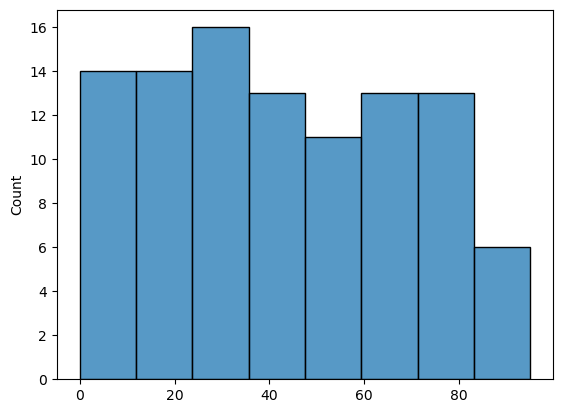

In [13]:

N = 100
threads_per_block = 32
blocks = math.ceil( N/threads_per_block )

fitness_array = np.ones( N , dtype = np.float32 ) # simple test with all fitness = 1
out = np.zeros(N, dtype=np.int32)

## sending data to device
fitness_array_device = cuda.to_device(fitness_array)
out_device = cuda.to_device(out)


fitness_sum=sum_reduce(fitness_array_device)

multinomial[blocks, threads_per_block](rng_states,
                                     out_device,
                                     fitness_array_device,
                                     fitness_sum)


out_device.copy_to_host(out)

#plt.hist(out)
sns.histplot(out)

<Axes: ylabel='Count'>

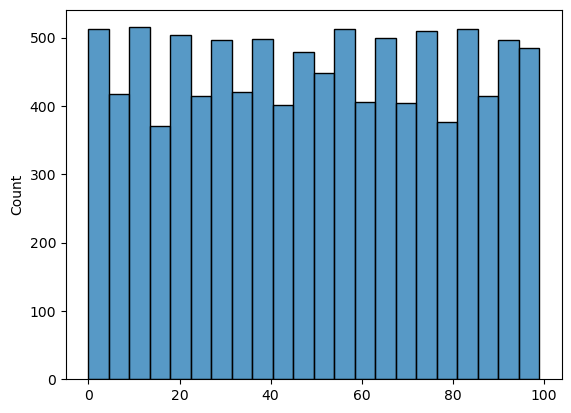

In [14]:
## let's repeat the computation to handle random variability:
out_cumul = out
for i in range(100):
  multinomial[blocks, threads_per_block](rng_states,
                                      out_device,
                                      fitness_array_device,
                                      fitness_sum)

  out_device.copy_to_host(out)

  out_cumul = np.concat([out_cumul,out])
sns.histplot(out_cumul)

<Axes: ylabel='Count'>

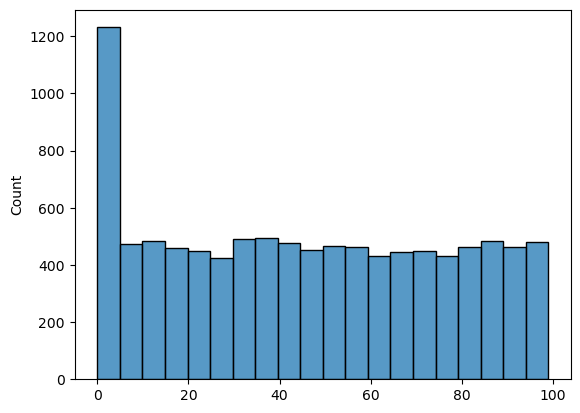

In [15]:
fitness_array[0] = 10 # give parent 0 a high fitness
fitness_array_device = cuda.to_device(fitness_array)
fitness_sum=sum_reduce(fitness_array_device)


out_cumul = np.empty(0,dtype=np.int32)
for i in range(100):
  multinomial[blocks, threads_per_block](rng_states,
                                      out_device,
                                      fitness_array_device,
                                      fitness_sum)

  out_device.copy_to_host(out)

  out_cumul = np.concat([out_cumul,out])
sns.histplot(out_cumul)

## 2. mutating the genomes

Second we want to handle mutation between the parent and the children genomes.

Remember that we set things up so that one genome is handled per thread.

Presuming a fixed rate of mutation *$\mu$* per nucleotide and a fixed genome size $N$, there could be two ways of implementing this.

 1. iterate through each nucleotide. For each nucleotide draw a random probability, if this probability is $< \mu$ then mutate this nucleotide
 2. precompute the cumulative mass function of the binomial corresponding to the number of mutation per genome $\mathcal{B}(\mu,N)$ and then draw a corresponding number of positions where these mutations occur


For the mutation process itself, we will use something relatively simple where the there is an equal probability of shifting from any nucleotide to any other (taking into account different rates of transition/transversion could be a later refinement).

In [16]:

genome = np.ones( 10 , dtype = "u1" )

mutation = 1+int(3*np.random.random())

genome[0] = (genome[0] + mutation)%4 # modulo 4 -> so we cycle between 0 and 3

genome

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [17]:
## first approach : go through each position and check for mutation

@cuda.jit
def mutate_genome( rng_states, genomes , mutation_proba ):

  cellID = cuda.grid(1)
  if cellID >= genomes.shape[0]:
    return

  genome_size = genomes.shape[1]

  for pos in range( genome_size ):
    r = rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
    if r < mutation_proba:
        ## I re-use the random roll: divide by mutation_proba and then make it
        ## an int between 1 and 3
        mut = 1+ int( 3*r/mutation_proba )
        genomes[cellID, pos] = ( genomes[cellID, pos]+mut)%4




In [18]:
# Let's try it on simple data
number_of_genomes = 1000
genome_size = 50
mut_proba = 0.3 # for this test, let's make mutations highly likely

genomes = np.zeros( (number_of_genomes , genome_size) , dtype = "u1" )


## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )


genomes_device = cuda.to_device(genomes)

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

mutate_genome[blocks, threads_per_block]( rng_states, genomes_device , mut_proba)


genomes = genomes_device.copy_to_host()
genomes[:5,:10]

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


array([[2, 0, 3, 0, 3, 0, 0, 0, 0, 0],
       [0, 3, 0, 1, 3, 2, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 3, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0]], dtype=uint8)

Let's check that the number of observed mutations match the expectations:

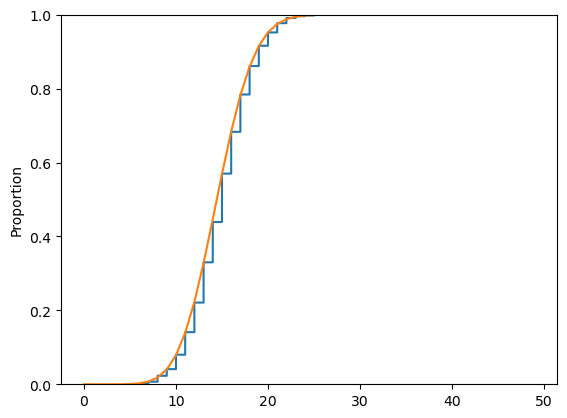

In [19]:
sns.ecdfplot( ( genomes !=0 ).sum(axis=1) )
plt.plot( binom( genome_size, mut_proba ).cdf(range(genome_size)) )

In [20]:
## second approach: draw the next mutated positions using a negative binomial distribution

from scipy.stats import nbinom
## Negative binomial distribution describes a sequence of i.i.d. Bernoulli trials, repeated until a predefined, non-random number of successes occurs.
## in our case, successes are mutations
## so we go until 1 "success" occurs to know where the tentatively first mutation occurs

genome_size = 100
mut_proba = 0.05

neg_bin_distrib = nbinom(n=1,p=mut_proba)

i=neg_bin_distrib.rvs()## drawing from distribution: give us the number of positions without mutations
while i < genome_size:
  print(i)
  i += neg_bin_distrib.rvs() +1 ## the +1 represent the mutated position



4
10
23
38
55
65


In [21]:
def build_nbinom_cdf( genome_size,mut_proba ):
  neg_bin_distrib = nbinom(n=1,p=mut_proba)
  cdf = neg_bin_distrib.cdf( range( genome_size ) )
  return cdf

build_nbinom_cdf( 10,mut_proba )

array([0.05      , 0.0975    , 0.142625  , 0.18549375, 0.22621906,
       0.26490811, 0.3016627 , 0.33657957, 0.36975059, 0.40126306])

In [22]:
@cuda.jit(device=True)
def next_mutated_pos(rng_states,nbinom_cdf):
  cellID = cuda.grid(1)

  r=rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
  pos = len(nbinom_cdf) ## default -> return the size of the cdf, which corresponds to the genome size
  for i in range(len(nbinom_cdf)):
    if r < nbinom_cdf[i]:
      pos = i
      break
  return pos



@cuda.jit
def mutate_genome2( rng_states, genomes, nbinom_cdf ):

  cellID = cuda.grid(1)
  if cellID >= genomes.shape[0]:
    return

  pos = next_mutated_pos(rng_states,nbinom_cdf)
  while pos < genomes.shape[1]:
    # mutation:
    mut = 1 + int( 3*rnd.xoroshiro128p_uniform_float32(rng_states, cellID) )
    genomes[cellID, pos] = ( genomes[cellID, pos]+mut)%4

    pos += next_mutated_pos(rng_states,nbinom_cdf)+1




In [23]:
# Let's try it on simple data
number_of_genomes = 1000
genome_size = 50
mut_proba = 0.3 # for this test, let's make mutations highly likely

genomes = np.zeros( (number_of_genomes , genome_size) , dtype = "u1" )

nbinom_cdf = build_nbinom_cdf(genome_size,mut_proba)


## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

genomes_device = cuda.to_device(genomes)

nbinom_cdf_device = cuda.to_device( nbinom_cdf )

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=46521)

mutate_genome2[blocks, threads_per_block]( rng_states, genomes_device , nbinom_cdf_device )


genomes = genomes_device.copy_to_host()
genomes[:5,:10]

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


array([[0, 3, 1, 0, 0, 0, 0, 2, 2, 0],
       [0, 0, 2, 0, 0, 0, 2, 0, 0, 1],
       [0, 0, 0, 1, 3, 0, 1, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

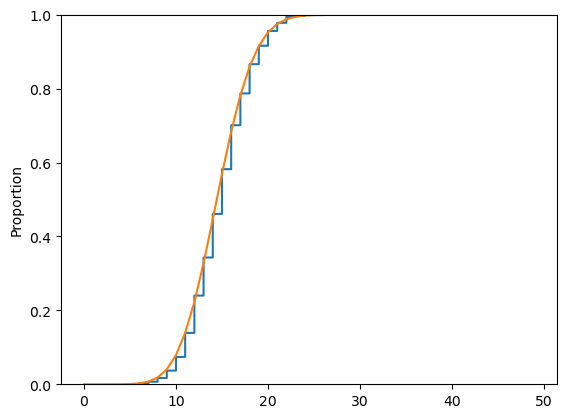

In [24]:
sns.ecdfplot( ( genomes !=0 ).sum(axis=1) )
plt.plot( binom( genome_size, mut_proba ).cdf(range(genome_size)) )

Which of the two approach is the best?

Approach 1. makes more operations (1 per nucleotide) but
approach 2. has a structure less appropriate to GPU structure, with several loops of different sizes between the threads.


The performances are likely to depend on parameters specific values, in particular the ratio of genome size and mutation probability

In [25]:
%%time
## let's create bigger data:
number_of_genomes = 1000
genome_size = 100_000
mut_proba = 10**-5


genomes = np.zeros( (number_of_genomes , genome_size) , dtype = "u1" )

nbinom_cdf = build_nbinom_cdf(genome_size,mut_proba)


## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

genomes_device = cuda.to_device(genomes)

nbinom_cdf_device = cuda.to_device( nbinom_cdf )

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=46521)

CPU times: user 10.1 ms, sys: 8.66 ms, total: 18.8 ms
Wall time: 17.1 ms


In [26]:
%%timeit -n 5 -r 5
mutate_genome[blocks, threads_per_block]( rng_states, genomes_device , mut_proba)

176 μs ± 56 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [27]:
%%timeit -n 5 -r 5
mutate_genome2[blocks, threads_per_block]( rng_states, genomes_device , nbinom_cdf_device )

179 μs ± 91.5 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


It seems that here they have very similar performance.

> NB: we could perform some refinement on these implementations, among other by managing how we store some elements such as the negative binomial CDF on the GPU, but that is a topic for the next chapter.

## 3. additionnal tasks : copying parents and updating the fitness array

After children have selected their parent, we need to populate the children genomes with the parent genomes before mutating it


In [28]:



@cuda.jit
def copy_genomes( parents_genomes, children_genomes , parent_attribution ):

  cellID = cuda.grid(1)
  if cellID >= parents_genomes.shape[0]:
    return
  parentID = parent_attribution[ cellID ]

  for i in range(parents_genomes.shape[1]):
    children_genomes[ cellID , i ] = parents_genomes[ parentID , i ]



## let's some toy data:
number_of_genomes = 1000
genome_size = 100


parents_genomes = np.random.randint(0,4,
                            size = (number_of_genomes,genome_size),
                            dtype='u1')
children_genomes = np.zeros( (number_of_genomes,genome_size),
                            dtype='u1')

parent_attribution = np.random.randint(0, number_of_genomes,
                            size = number_of_genomes)


threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

copy_genomes[ blocks, threads_per_block ]( parents_genomes, children_genomes , parent_attribution )

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))
/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:934: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))



once the genome have mutated, we need to re-compute their fitness before the next generation.

Once again we are going to keep this relatively simple and say that we are operating under a form of purifying selection where each mutation from the reference degrades fitness.

More formally, for a genome with $n$ differences to the reference the fitness is equal to $s^n$, where $s$ is a coefficient below 1.


In [61]:


@cuda.jit
def compute_fitness( genomes, reference , fitness_array ):

  cellID = cuda.grid(1)
  if cellID >= genomes.shape[0]:
    return

  n = 0
  for i in range(genomes.shape[1]):
    n += (genomes[cellID,i] != reference[i])
  fitness_array[cellID] = s**n



In [62]:
## let's some toy data:
number_of_genomes = 1000
genome_size = 100

s = 0.999


genomes = np.random.randint(0,4,
                            size = (number_of_genomes,genome_size),
                            dtype='u1')

reference = np.zeros( genome_size,
                      dtype='u1')

fitness_array = np.zeros(number_of_genomes)

## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

genomes_device = cuda.to_device(genomes)
reference_device = cuda.to_device( reference )
fitness_array_device = cuda.to_device( fitness_array )

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=46521)


compute_fitness[ blocks, threads_per_block ]( genomes_device,
                                              reference_device ,
                                              fitness_array_device )

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


(array([  2.,  29.,  66., 191., 188., 244., 141.,  97.,  27.,  15.]),
 array([0.91572056, 0.91803989, 0.92035922, 0.92267855, 0.92499789,
        0.92731722, 0.92963655, 0.93195588, 0.93427521, 0.93659455,
        0.93891388]),
 <BarContainer object of 10 artists>)

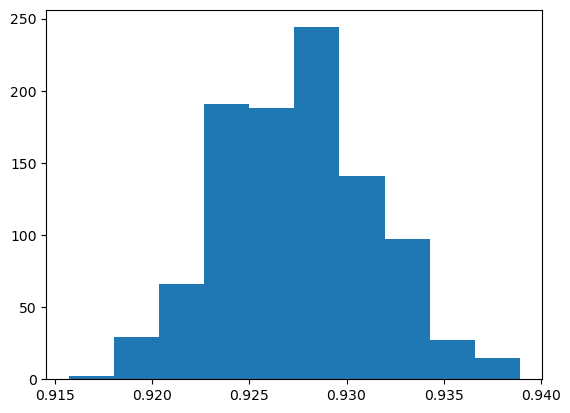

In [63]:
fitness_array = fitness_array_device.copy_to_host()
plt.hist( fitness_array )


In [64]:

for i,gen in enumerate( genomes[:10,:] ):
    n = np.sum( gen != reference  )
    print( f"number of mutations: {n} -  CPU fitness: {s**n} - GPU fitness: {fitness_array[i]} - same: {np.isclose(s**n , fitness_array[i])}" )

number of mutations: 65 -  CPU fitness: 0.9370369888620197 - GPU fitness: 0.9370369888620201 - same: True
number of mutations: 72 -  CPU fitness: 0.9304973749532336 - GPU fitness: 0.9304973749532341 - same: True
number of mutations: 78 -  CPU fitness: 0.9249283295681429 - GPU fitness: 0.9249283295681435 - same: True
number of mutations: 84 -  CPU fitness: 0.9193926150309794 - GPU fitness: 0.91939261503098 - same: True
number of mutations: 75 -  CPU fitness: 0.9277086733900014 - GPU fitness: 0.927708673390002 - same: True
number of mutations: 72 -  CPU fitness: 0.9304973749532336 - GPU fitness: 0.9304973749532341 - same: True
number of mutations: 68 -  CPU fitness: 0.9342286880693632 - GPU fitness: 0.9342286880693638 - same: True
number of mutations: 71 -  CPU fitness: 0.9314288037569906 - GPU fitness: 0.9314288037569911 - same: True
number of mutations: 79 -  CPU fitness: 0.9240034012385747 - GPU fitness: 0.9240034012385753 - same: True
number of mutations: 79 -  CPU fitness: 0.9240034

## 4. putting everything together

In [65]:
## let's some toy data:
number_of_genomes = 10_000
genome_size = 10_000
mut_proba = 10**-5
s = 0.999


threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )



## holds the genomes for the older and the new generation
genomes_device = [
    cuda.to_device( np.random.randint(0,4,
                            size = (number_of_genomes,genome_size),
                            dtype='u1') ),
    cuda.to_device( np.zeros( (number_of_genomes,genome_size),
                            dtype='u1') )
]

# "reference" genomes (ie, max fitness)
reference_device = cuda.to_device( np.zeros( genome_size,
                      dtype='u1') )

# array of fitnesses
fitness_array_device = cuda.to_device( np.ones(number_of_genomes) )

# array of parent attribution
parent_attribution_device = cuda.to_device( np.zeros(number_of_genomes, dtype = np.int32) )

# random states
rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)



## first fitness computation
compute_fitness[ blocks, threads_per_block ]( genomes_device[0],
                                              reference_device ,
                                              fitness_array_device )

In [66]:
A = fitness_array_device.copy_to_host()
print("mean fitness:",A.mean())
print("max fitness:",A.max())

mean fitness: 0.0005514757591589392
max fitness: 0.0006492644526299072


Let's do a single round of evolution:

In [67]:
%%time
## computing fitness sum:
fitness_sum=sum_reduce(fitness_array_device)

## parent attribution
multinomial[blocks, threads_per_block](rng_states,
                                     parent_attribution_device,
                                     fitness_array_device,
                                     fitness_sum)

## copying parents
copy_genomes[ blocks, threads_per_block ]( genomes_device[0],
                                           genomes_device[1],
                                           parent_attribution_device )

## mutating genomes
mutate_genome[blocks, threads_per_block]( rng_states,
                                          genomes_device[1] ,
                                          mut_proba )

## update fitness
compute_fitness[ blocks, threads_per_block ]( genomes_device[1],
                                              reference_device ,
                                              fitness_array_device )

A = fitness_array_device.copy_to_host()
print("mean fitness:",A.mean())
print("max fitness:",A.max())

mean fitness: 0.0005526555793143079
max fitness: 0.0006492644526299072
CPU times: user 10.3 ms, sys: 321 μs, total: 10.6 ms
Wall time: 8.75 ms


To make several generations, we are going to repeat the operation, but each time we will shift which of the two element of `genomes_device` we use for the parents and for the children

In [68]:
%%time
nb_generations = 1000

for i in range(  nb_generations ):

  ## on even generations, parents are in index 0, children in index 1
  ## on odd generations we do the converse
  parents_index , children_index = 0,1
  if i%2==1:
    parents_index , children_index = 1,0

  ## computing fitness sum:
  fitness_sum=sum_reduce(fitness_array_device)

  ## parent attribution
  multinomial[blocks, threads_per_block](rng_states,
                                      parent_attribution_device,
                                      fitness_array_device,
                                      fitness_sum)

  ## copying parents
  copy_genomes[ blocks, threads_per_block ]( genomes_device[parents_index],
                                             genomes_device[children_index],
                                             parent_attribution_device )

  ## mutating genomes
  mutate_genome[blocks, threads_per_block]( rng_states,
                                            genomes_device[children_index] ,
                                            mut_proba )

  ## update fitness
  compute_fitness[ blocks, threads_per_block ]( genomes_device[children_index],
                                                reference_device ,
                                                fitness_array_device )

  if i%100 == 0:
    A = fitness_array_device.copy_to_host()
    print(f"generation {i:>3} : mean fitness: {A.mean():.5f}\t|\tmax fitness: {A.max():.5f}\t")

generation   0 : mean fitness: 0.00055	|	max fitness: 0.00064	
generation 100 : mean fitness: 0.00062	|	max fitness: 0.00064	
generation 200 : mean fitness: 0.00063	|	max fitness: 0.00064	
generation 300 : mean fitness: 0.00063	|	max fitness: 0.00064	
generation 400 : mean fitness: 0.00063	|	max fitness: 0.00064	
generation 500 : mean fitness: 0.00064	|	max fitness: 0.00064	
generation 600 : mean fitness: 0.00064	|	max fitness: 0.00065	
generation 700 : mean fitness: 0.00064	|	max fitness: 0.00065	
generation 800 : mean fitness: 0.00064	|	max fitness: 0.00065	
generation 900 : mean fitness: 0.00064	|	max fitness: 0.00065	
CPU times: user 5.96 s, sys: 1.19 ms, total: 5.96 s
Wall time: 5.94 s


From this "simple" implementation, many refinement can be added,

from the standpoint of the simulation:
 * more complex mutation patterns
 * more complex fitness computation

from the standpoint of performance:
 * some objects could be transfered to some specific cache of the GPU (more on that in the next session)
 * the "genomes" could be implemented with a custom type representing a nucleotide with 2 bits instead of a full byte (=8b)


In [53]:
## numpy implementation

number_of_genomes = 10_000
genome_size = 10_000
mut_proba = 10**-5
s = 0.999


genomes = np.random.randint(0,4, size = (number_of_genomes,genome_size), dtype='u1')

# "reference" genomes (ie, max fitness)
reference = np.zeros( genome_size, dtype='u1')

In [54]:
from numba import njit

def compute_fitness( genomes , reference, s ):
  return s**(genomes == reference).sum(axis=1)


def attribute_and_copy_parent( genomes, fitness_array ):
  number_of_genomes = genomes.shape[0]
  parent_attribution = np.random.choice(number_of_genomes ,
                                      number_of_genomes ,
                                      replace=True,
                                      p=fitness_array/fitness_array.sum())
  return genomes[parent_attribution,:]

def mutate(genomes , mut_proba):
  number_of_genomes,genome_size = genomes.shape
  has_mutation = np.random.random( (number_of_genomes,genome_size) ) < mut_proba
  mutation = has_mutation * np.random.randint( 1,3, (number_of_genomes,genome_size) )
  return (genomes + mutation) %4



In [55]:
from numba import prange
@njit
def mutate2(genomes , mut_proba):

  number_of_genomes,genome_size = genomes.shape

  for i in prange( number_of_genomes ):
    for j in range(genome_size):
      r = np.random.random()
      if r < mut_proba:
        r = 1+ int( (r/mut_proba)*3 )
        genomes[i,j] = (genomes[i,j]+r)%4

  return genomes

mutate2( np.zeros((10,5),dtype='u1') , 0.1)

array([[0, 0, 0, 0, 0],
       [1, 3, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [56]:
%%time
fitness_array = compute_fitness( genomes , reference , s )
genomes = attribute_and_copy_parent( genomes, fitness_array )
genomes = mutate2( genomes , mut_proba )

fitness_array = compute_fitness( genomes , reference , s )

CPU times: user 1.4 s, sys: 15.3 ms, total: 1.41 s
Wall time: 1.4 s


1s vs 50ms on the GPU

In [57]:
%%prun
genomes = attribute_and_copy_parent( genomes, fitness_array )
genomes = mutate2( genomes , mut_proba )

fitness_array = compute_fitness( genomes , reference , s )

         743 function calls (737 primitive calls) in 1.374 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    1.325    0.331    2.706    0.677 base_events.py:1922(_run_once)
        3    0.023    0.008    0.023    0.008 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.012    0.012    0.034    0.034 398811446.py:3(compute_fitness)
        1    0.007    0.007    0.007    0.007 398811446.py:7(attribute_and_copy_parent)
        2    0.004    0.002    0.004    0.002 {method '__exit__' of 'sqlite3.Connection' objects}
        1    0.001    0.001    0.001    0.001 {method 'execute' of 'sqlite3.Connection' objects}
       20    0.000    0.000    0.000    0.000 socket.py:623(send)
        2    0.000    0.000    0.000    0.000 zmqstream.py:546(_run_callback)
        3    0.000    0.000    0.000    0.000 selectors.py:451(select)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' ob

In [ ]:
`